<a href="https://colab.research.google.com/github/Arif-X/RNN-LSTM-UMP-JATIM/blob/master/UMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from keras import metrics
from keras.callbacks import EarlyStopping

In [222]:
import os
fileList = os.listdir("/content/")

In [223]:
kotaKabList = []
for file in fileList:
    kotaKabName = file.split("_")[0]
    if kotaKabName != "all":
        kotaKabList.append(kotaKabName)
print(kotaKabList)

['.config', 'UMP.csv', '.ipynb', 'Surabaya.csv', 'Kota Surabaya.csv', 'sample']


In [224]:
# umkList = ["Kab. Gresik", "Kab. Sidoarjo", "Kota Surabaya"]
umkList = ["UMP"]
df_ = {}
for i in umkList:
    df_[i] = pd.read_csv("/content/" + i + ".csv", index_col="Tahun", parse_dates=["Tahun"])

In [235]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in umkList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2016", "Ump")

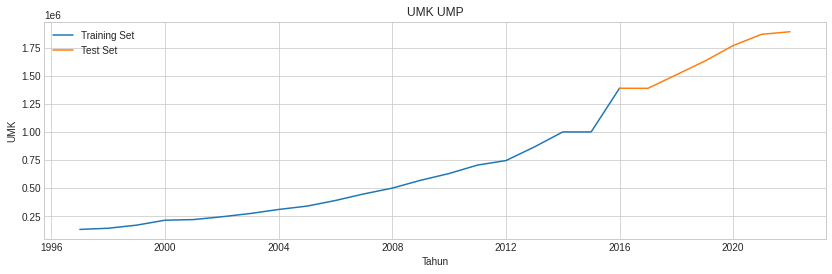

In [236]:
for i in umkList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("UMK")
    plt.xlabel("Tahun")
    plt.legend(["Training Set", "Test Set"])
    plt.title("UMK " + i)

In [237]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(umkList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    print(transform_train[i].shape)
    print(transform_test[i].shape)

del a0
del a1

(20, 1)
(7, 1)


In [238]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

UMP (20, 1)


UMP (7, 1)


In [239]:
trainset = {}
testset = {}
for j in umkList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(1, 20):
        X_train.append(transform_train[j][i-1:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train

    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(1, 7):
        X_test.append(transform_test[j][i-1:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [240]:
arr_buff = []
for i in umkList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)
    
pd.DataFrame(arr_buff, index=umkList)

,X_train,y_train,X_test,y_test
UMP,"(19, 1, 1)","(19,)","(6, 1, 1)","(6,)"


In [ ]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(
    optimizer='rmsprop',
    loss='mse',
)

# Fitting to the training set
for i in umkList:
    print("Fitting to", i)
    model = regressor.fit(
        trainset[i]["X"],
        trainset[i]["y"],
        epochs=1000,
        batch_size=3
    )

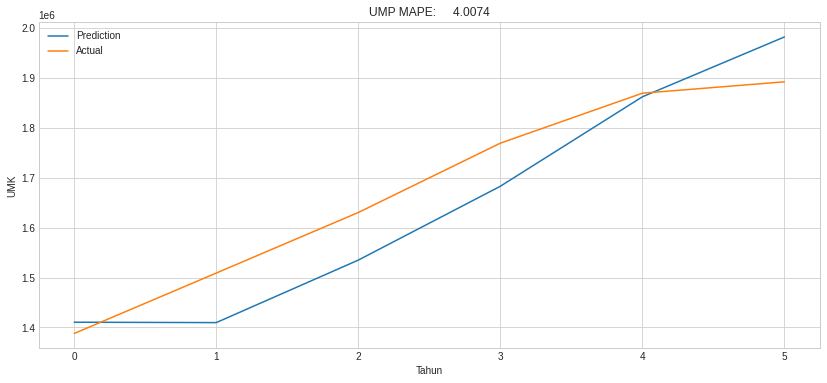

In [242]:
pred_result = {}

for i in umkList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred

    plt.figure(figsize=(14,6))
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    plt.title(i + " MAPE: {:10.4f}".format(mape(y_true, y_pred).numpy()))
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.legend(["Prediction", "Actual"])
    plt.xlabel("Tahun")
    plt.ylabel("UMK")
    plt.show()